Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 4.2) 강남역 맛집 리뷰로 알아보는 감성분석 

### 바로가기

- [<Step1. 크롤링> : 네이버 플레이스 리뷰 크롤링](#<Step1.-크롤링>-:-네이버-플레이스-리뷰-크롤링)
    - [네이버 플레이스 API]
    - [맛집 리뷰 정보 크롤링]
- [<Step2. 전처리> : TF-IDF를 이용한 핵심어 추출](#<Step2.-전처리>-:-TF\-IDF를-이용한-핵심어-추출)
    - [형태소 추출하기]
    - [TF-IDF 추출하기]
- [<Step3. 분류> : 긍정 부정 리뷰 분류하기](#<Step3.-분류>-:-긍정-부정-리뷰-분류하기)
    - [분류 모델링]
    - [분류 모델 개선]
- [<Step4. 분석> : 중요 키워드 분석](#<Step4.-분석>-:-중요-키워드-분석)
    - [회귀 모델의 변수중요도 추출]
    - [중요 변수의 형태소]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 크롤링> : 네이버 플레이스 리뷰 크롤링

### [네이버 플레이스 API]

![앱 생성 페이지](img/1.png)

-----

In [2]:
# 관련도순 상위 100개의 고기집 리스트 정보 API
import requests
import json

source_url = "https://store.naver.com/sogum/api/businesses?"
url_parameter_start = "start=1"
url_parameter_display = "&display=" # 번호 입력 필요
url_parameter_query = "&query=강남역+고기집"
url_parameter_sorting = "&sortingOrder=precision"
url_concat = source_url + url_parameter_start + \
            url_parameter_display + str(100) + url_parameter_query + url_parameter_sorting
json_data = requests.get(url_concat).text
restaurant_list_data = json.loads(json_data)
print(restaurant_list_data)

{'query': {'select': '1', 'item': [{'rank': '1', 'region_keyword': '강남역', 'region_type': 'favor', 'region_info': {'name': '강남역 2호선', 'fkey': '2', 'x': '1270276241', 'y': '374979526', 'spot_id': '13479290', 'bmap': '0', 'coordinates': {'coordinate': [{'x': '127.0272121', 'y': '37.4926153'}, {'x': '127.0228532', 'y': '37.5020801'}, {'x': '127.0292005', 'y': '37.5038361'}, {'x': '127.0334889', 'y': '37.4946773'}, {'x': '127.0272796', 'y': '37.4926696'}]}}, 'biz_type': 'category', 'biz': '고기집', 'coordinate_mode': '0'}, {'rank': '2', 'region_keyword': '', 'region_type': 'none', 'region_info': '', 'biz_type': 'unknown', 'biz': '강남역 고기집', 'coordinate_mode': '0'}], 'type': 'local', 'petrol': '0', 'global_menu': '0'}, 'total': 914, 'items': [{'id': '11609540', 'name': '봉우화로', 'businessCategory': 'restaurant', 'dbType': 'drt', 'category': '육류,고기요리', 'desc': '', 'hasBooking': True, 'hasNPay': False, 'x': '127.0273323', 'y': '37.5017679', 'distance': '8410.31', 'imageSrc': 'http://ldb.phinf.naver.

In [3]:
# 크롤링에 필요한 id 정보 추출
restaurant_id_list = []

for start_idx in [1, 101, 201, 301, 401, 501, 601, 701, 801, 901]:
    source_url = "https://store.naver.com/sogum/api/businesses?"
    url_parameter_start = "start=" + str(start_idx)
    url_parameter_display = "&display="
    url_parameter_query = "&query=강남역+고기집"
    url_parameter_sorting = "&sortingOrder=precision"
    url_concat = source_url + url_parameter_start + \
                url_parameter_display + str(start_idx+99) + url_parameter_query + url_parameter_sorting
    print("request_url:", url_concat)
    json_data = requests.get(url_concat).text
    restaurant_list_data = json.loads(json_data)

    for restaurant in restaurant_list_data['items']:
        if 'moreBookingReviewsPath' in restaurant:
            restaurant_id_list.append(restaurant['id'])

restaurant_id_list = list(set(restaurant_id_list))

request_url: https://store.naver.com/sogum/api/businesses?start=1&display=100&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=101&display=200&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=201&display=300&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=301&display=400&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=401&display=500&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=501&display=600&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=601&display=700&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=701&display=800&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=80

-----

### [맛집 리뷰 정보 크롤링]

![앱 생성 페이지](img/2.png)

-----

In [4]:
# 가져온 맛집 리스트의 리뷰 정보 크롤링
import requests
from bs4 import BeautifulSoup
import re

columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

source_url_head = "https://store.naver.com/restaurants/detail?id="
source_url_tail = "&tab=bookingReview#_tab"

for idx in range(0, len(restaurant_id_list)):
    print("Crawl", str(int(idx/len(restaurant_id_list)*100)), "% complete..")
    req = requests.get(source_url_head + str(restaurant_id_list[idx]) + source_url_tail)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    review_area = soup.find(name="div", attrs={"class":"review_area"})

    # 리뷰가 없는 페이지
    if review_area is None:
        continue

    review_list = review_area.find_all(name="div", attrs={"class":"info_area"})
    for review in review_list:
        score = review.find(name="span", attrs={"class":"score"}).text
        review_txt = review.find(name="div", attrs={"class":"review_txt"}).text

        # to dataframe
        row = [score, review_txt]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
print("Crawl 100 %", "complete")

Crawl 0 % complete..
Crawl 1 % complete..
Crawl 2 % complete..
Crawl 4 % complete..
Crawl 5 % complete..
Crawl 6 % complete..
Crawl 8 % complete..
Crawl 9 % complete..
Crawl 10 % complete..
Crawl 12 % complete..
Crawl 13 % complete..
Crawl 15 % complete..
Crawl 16 % complete..
Crawl 17 % complete..
Crawl 19 % complete..
Crawl 20 % complete..
Crawl 21 % complete..
Crawl 23 % complete..
Crawl 24 % complete..
Crawl 26 % complete..
Crawl 27 % complete..
Crawl 28 % complete..
Crawl 30 % complete..
Crawl 31 % complete..
Crawl 32 % complete..
Crawl 34 % complete..
Crawl 35 % complete..
Crawl 36 % complete..
Crawl 38 % complete..
Crawl 39 % complete..
Crawl 41 % complete..
Crawl 42 % complete..
Crawl 43 % complete..
Crawl 45 % complete..
Crawl 46 % complete..
Crawl 47 % complete..
Crawl 49 % complete..
Crawl 50 % complete..
Crawl 52 % complete..
Crawl 53 % complete..
Crawl 54 % complete..
Crawl 56 % complete..
Crawl 57 % complete..
Crawl 58 % complete..
Crawl 60 % complete..
Crawl 61 % complet

In [5]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가
df['y'] = df['score'].apply(lambda x: 1 if int(x) > 3 else 0)
print(df.shape)
df.head()

(556, 3)


,score,review,y
0,4,고기도 너무 맛있었구요\n같이 나오는 반찬이랑 특히 된장찌개!!!!!!계란찜!!!!...,1
1,1,회식하는데 예약을 했는데 길을 찾는게 낮아져서 약 십분정도 늦어질것 같아 미리 가게...,0
2,5,한상가득!!! 추천합니다!!!,1
3,5,최근에 자주 가는데 역시 갈 때마다 예약하고 갑니다\n서비스 좋고 고기 맛도 좋네요...,1
4,5,한점 더먹고 오지못한게 너무아쉬운 ㅜ\n갈때마다 배터지게 먹어도 더못먹은게 매번 후...,1


In [6]:
df.to_csv("review_data.csv", index=False)
df = pd.read_csv("review_data.csv")

-----

# <Step2. 전처리> : TF-IDF를 이용한 핵심어 추출

### [형태소 추출하기]

##### 한글 텍스트로 전처리

In [7]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식
    result = hangul.sub('', text)
    return result

In [8]:
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']
df.head()

,score,y,ko_text
0,4,1,고기도 너무 맛있었구요같이 나오는 반찬이랑 특히 된장찌개계란찜다음엔 꼭 밥을 시켜서...
1,1,0,회식하는데 예약을 했는데 길을 찾는게 낮아져서 약 십분정도 늦어질것 같아 미리 가게...
2,5,1,한상가득 추천합니다
3,5,1,최근에 자주 가는데 역시 갈 때마다 예약하고 갑니다서비스 좋고 고기 맛도 좋네요다음...
4,5,1,한점 더먹고 오지못한게 너무아쉬운 ㅜ갈때마다 배터지게 먹어도 더못먹은게 매번 후회되...


-----

##### 형태소 단위로 추출

In [9]:
from konlpy.tag import Twitter

def get_pos(x):
    tagger = Twitter()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작 테스트
result = get_pos(df['ko_text'][0])
print(result)

['고기/Noun', '도/Josa', '너무/Adverb', '맛있었구요/Adjective', '같이/Adverb', '나오는/Verb', '반찬/Noun', '이랑/Josa', '특히/Adverb', '된장찌개/Noun', '계란찜/Noun', '다음/Noun', '엔/Josa', '꼭/Noun', '밥/Noun', '을/Josa', '시켜서/Verb', '말아먹어야겠습니다/Verb', '재/Noun', '방문/Noun', '의사/Noun', '뿜뿜/Noun']


-----

### [TF-IDF 추출하기]

##### corpus index 생성하기

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

In [11]:
X.shape

(556, 3074)

In [12]:
print(index_vectorizer.vocabulary_)

{'고기/Noun': 234, '도/Josa': 733, '너무/Adverb': 539, '맛있었구요/Adjective': 1041, '같이/Adverb': 171, '나오는/Verb': 485, '반찬/Noun': 1265, '이랑/Josa': 2146, '특히/Adverb': 2781, '된장찌개/Noun': 797, '계란찜/Noun': 226, '다음/Noun': 646, '엔/Josa': 1940, '꼭/Noun': 451, '밥/Noun': 1287, '을/Josa': 2117, '시켜서/Verb': 1655, '말아먹어야겠습니다/Verb': 1010, '재/Noun': 2312, '방문/Noun': 1289, '의사/Noun': 2125, '뿜뿜/Noun': 1477, '회식/Noun': 3046, '하는데/Verb': 2871, '예약/Noun': 1986, '했는데/Verb': 2997, '길/Noun': 415, '찾는게/Verb': 2622, '낮아져서/Verb': 523, '약/Noun': 1839, '십분/Noun': 1688, '정도/Noun': 2370, '늦어질것/Verb': 609, '같아/Adjective': 161, '미리/Noun': 1220, '가게/Noun': 28, '에/Josa': 1929, '양/Modifier': 1846, '해전/Noun': 2969, '화/Suffix': 3025, '를/Josa': 919, '드렸어요/Verb': 822, '그런데/Conjunction': 360, '대뜸/Noun': 692, '늦어지는/Verb': 608, '시간/Noun': 1635, '차라리/Noun': 2604, '다른/Noun': 633, '손님/Noun': 1587, '받는게/Verb': 1273, '낫다/Noun': 519, '는/Josa': 600, '식/Noun': 1664, '으로/Josa': 2114, '말/Noun': 1004, '하셔서/Verb': 2886, '굉장히/Adjective': 281, '불쾌했

In [13]:
print(df['ko_text'][0])
print(X[0, 1068])
print(X[0])

고기도 너무 맛있었구요같이 나오는 반찬이랑 특히 된장찌개계란찜다음엔 꼭 밥을 시켜서 말아먹어야겠습니다재방문의사 뿜뿜
0
  (0, 1477)	1
  (0, 2125)	1
  (0, 1289)	1
  (0, 2312)	1
  (0, 1010)	1
  (0, 1655)	1
  (0, 2117)	1
  (0, 1287)	1
  (0, 451)	1
  (0, 1940)	1
  (0, 646)	1
  (0, 226)	1
  (0, 797)	1
  (0, 2781)	1
  (0, 2146)	1
  (0, 1265)	1
  (0, 485)	1
  (0, 171)	1
  (0, 1041)	1
  (0, 539)	1
  (0, 733)	1
  (0, 234)	1


-----

##### TF-IDF로 변환

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [15]:
print(X.shape)
print(X[0])

(556, 3074)
  (0, 2781)	0.23252654255429128
  (0, 2312)	0.19909762476238754
  (0, 2146)	0.19656271444689502
  (0, 2125)	0.21840348360657694
  (0, 2117)	0.1486694900102282
  (0, 1940)	0.20770822206131592
  (0, 1655)	0.2632668276691996
  (0, 1477)	0.29400711278410796
  (0, 1289)	0.15794247223049565
  (0, 1287)	0.20770822206131592
  (0, 1265)	0.20178625743938294
  (0, 1041)	0.2632668276691996
  (0, 1010)	0.29400711278410796
  (0, 797)	0.21840348360657694
  (0, 733)	0.08698021889224967
  (0, 646)	0.16968128443797048
  (0, 539)	0.12095908526936404
  (0, 485)	0.24528491361550148
  (0, 451)	0.21099482591282812
  (0, 234)	0.11026382372410307
  (0, 226)	0.2632668276691996
  (0, 171)	0.22263038113095449


-----

# <Step3. 분류> : 긍정 부정 리뷰 분류하기

### [분류 모델링]

##### 데이터셋 분리

In [16]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(x_train.shape)
print(x_test.shape)

(389, 3074)
(167, 3074)


-----

##### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.93
Precision : 0.928
Recall : 1.000
F1 : 0.963


In [18]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[  0  12]
 [  0 155]]


AUC : 0.928


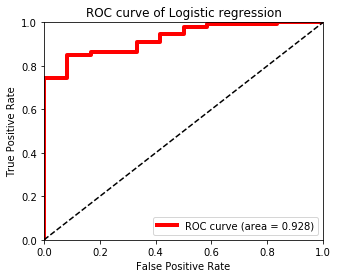

In [19]:
# AUC (Area Under the Curve) & ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve plot
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

------

### [분류 모델 개선]

##### 클래스 불균형 문제 해결하기

In [20]:
df['y'].value_counts()

1    504
0     52
Name: y, dtype: int64

In [21]:
# 1:1 비율로 랜덤 샘플링
positive_random_idx = df[df['y']==1].sample(50, random_state=30).index.tolist()
negative_random_idx = df[df['y']==0].sample(50, random_state=30).index.tolist()

In [22]:
# 랜덤 데이터로 데이터셋 나누기
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.30, random_state=40)
print(x_train.shape)
print(x_test.shape)

(70, 3074)
(30, 3074)


-----

##### Logistic Regression 다시 학습

In [23]:
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.73
Precision : 0.714
Recall : 0.714
F1 : 0.714


In [24]:
# confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[12  4]
 [ 4 10]]


AUC : 0.862


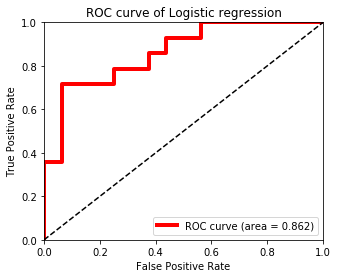

In [25]:
# AUC (Area Under the Curve) & ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve plot
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

-----

# <Step4. 분석> : 중요 키워드 분석

### [회귀 모델의 변수중요도 추출]

<BarContainer object of 3074 artists>

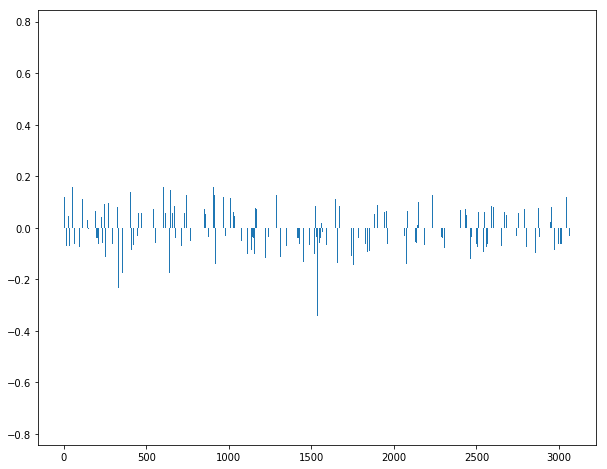

In [26]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [27]:
abs(lr.coef_[0])

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

[(0.7689327837239531, 1036),
 (0.43563769760481236, 2371),
 (0.39475186821576874, 1156),
 (0.34850801887616806, 126),
 (0.34471666998044087, 2419),
 (0.3410985390497016, 1112),
 (0.3299474284142872, 1031),
 (0.3289306114827572, 1411),
 (0.3218596120089303, 1024),
 (0.30688171128357883, 1576),
 (0.29629411184261306, 1049),
 (0.29609852204472403, 618),
 (0.2698732457244118, 2225),
 (0.2667977156013306, 1409),
 (0.25255161802420323, 1159),
 (0.23236082920422335, 21),
 (0.23131183505581043, 684),
 (0.23002402144376832, 8),
 (0.22296340464479228, 1017),
 (0.2227438565373262, 619),
 (0.21945109472831054, 2487),
 (0.21814929390961796, 106),
 (0.21777305340691794, 2659),
 (0.2152440785332877, 1019),
 (0.21275215025935332, 981),
 (0.20958098663978803, 974),
 (0.20930767844164336, 2691),
 (0.20183899360308982, 2407),
 (0.19640014605482534, 1602),
 (0.19458886032886863, 2045),
 (0.1901857283718155, 1571),
 (0.1880609702090767, 968),
 (0.1870878811336018, 1000),
 (0.1820042163045119, 1890),
 (0.17

-----

### [중요 변수의 형태소]

In [29]:
high_coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [30]:
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}
print(invert_index_vectorizer)

{234: '고기/Noun', 733: '도/Josa', 539: '너무/Adverb', 1041: '맛있었구요/Adjective', 171: '같이/Adverb', 485: '나오는/Verb', 1265: '반찬/Noun', 2146: '이랑/Josa', 2781: '특히/Adverb', 797: '된장찌개/Noun', 226: '계란찜/Noun', 646: '다음/Noun', 1940: '엔/Josa', 451: '꼭/Noun', 1287: '밥/Noun', 2117: '을/Josa', 1655: '시켜서/Verb', 1010: '말아먹어야겠습니다/Verb', 2312: '재/Noun', 1289: '방문/Noun', 2125: '의사/Noun', 1477: '뿜뿜/Noun', 3046: '회식/Noun', 2871: '하는데/Verb', 1986: '예약/Noun', 2997: '했는데/Verb', 415: '길/Noun', 2622: '찾는게/Verb', 523: '낮아져서/Verb', 1839: '약/Noun', 1688: '십분/Noun', 2370: '정도/Noun', 609: '늦어질것/Verb', 161: '같아/Adjective', 1220: '미리/Noun', 28: '가게/Noun', 1929: '에/Josa', 1846: '양/Modifier', 2969: '해전/Noun', 3025: '화/Suffix', 919: '를/Josa', 822: '드렸어요/Verb', 360: '그런데/Conjunction', 692: '대뜸/Noun', 608: '늦어지는/Verb', 1635: '시간/Noun', 2604: '차라리/Noun', 633: '다른/Noun', 1587: '손님/Noun', 1273: '받는게/Verb', 519: '낫다/Noun', 600: '는/Josa', 1664: '식/Noun', 2114: '으로/Josa', 1004: '말/Noun', 2886: '하셔서/Verb', 281: '굉장히/Adjective', 1421

In [31]:
# 상위 100개 중요 단어 출력
for coef in high_coef_pos_index[:100]:
    print(invert_index_vectorizer[coef[1]], coef[0])

맛있어요/Adjective 0.7689327837239531
정말/Noun 0.43563769760481236
모두/Noun 0.39475186821576874
감사합니다/Verb 0.34850801887616806
좋고/Adjective 0.34471666998044087
먹었습니다/Verb 0.3410985390497016
맛있습니다/Adjective 0.3299474284142872
분위기/Noun 0.3289306114827572
맛있네요/Adjective 0.3218596120089303
소세지/Noun 0.30688171128357883
맛있었어요/Adjective 0.29629411184261306
님/Suffix 0.29609852204472403
입니다/Adjective 0.2698732457244118
분들/Suffix 0.2667977156013306
모로/Noun 0.25255161802420323
ㅠㅠㅠㅠㅠㅠ/KoreanParticle 0.23236082920422335
대/Modifier 0.23131183505581043
ㅎㅎ/KoreanParticle 0.23002402144376832
맛있게/Adjective 0.22296340464479228
다/Adverb 0.2227438565373262
주인/Noun 0.21945109472831054
갈거에요/Verb 0.21814929390961796
최고/Noun 0.21777305340691794
맛있고/Adjective 0.2152440785332877
만족합니다/Adjective 0.21275215025935332
만족스런/Adjective 0.20958098663978803
친절하셨어요/Adjective 0.20930767844164336
존맛/Noun 0.20183899360308982
수제/Noun 0.19640014605482534
완전/Noun 0.19458886032886863
소고기/Noun 0.1901857283718155
만족스러운/Adjective 0.18806

In [32]:
# 품사별 랭킹
noun_list = []
adjective_list = []

for coef in high_coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [33]:
noun_list[:10]

[('정말/Noun', 0.43563769760481236),
 ('모두/Noun', 0.39475186821576874),
 ('분위기/Noun', 0.3289306114827572),
 ('소세지/Noun', 0.30688171128357883),
 ('모로/Noun', 0.25255161802420323),
 ('주인/Noun', 0.21945109472831054),
 ('최고/Noun', 0.21777305340691794),
 ('존맛/Noun', 0.20183899360308982),
 ('수제/Noun', 0.19640014605482534),
 ('완전/Noun', 0.19458886032886863)]

In [34]:
adjective_list[:10]

[('맛있어요/Adjective', 0.7689327837239531),
 ('좋고/Adjective', 0.34471666998044087),
 ('맛있습니다/Adjective', 0.3299474284142872),
 ('맛있네요/Adjective', 0.3218596120089303),
 ('맛있었어요/Adjective', 0.29629411184261306),
 ('입니다/Adjective', 0.2698732457244118),
 ('맛있게/Adjective', 0.22296340464479228),
 ('맛있고/Adjective', 0.2152440785332877),
 ('만족합니다/Adjective', 0.21275215025935332),
 ('만족스런/Adjective', 0.20958098663978803)]